# Open problems: single cell perturbation
## Preprocessing perturbation data
### by Jalil Nourisa

# Imports

In [1]:
import os, binascii
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scanpy as sc
import pandas as pd
import numpy as np
import random
import anndata as ad
from matplotlib.patches import Patch
import warnings
from scipy import sparse
import scvi
import scib

# local imports
from local_utils import plots

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/py10/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/root/anaconda3/envs/py10/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_645051/2550031192.py:27: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed 

In [54]:
batch_key = 'plate_name'
label_key = 'cell_type'

colors_cell_type = ['#c4d9b3', '#c5bc8e', '#c49e81', '#c17d88', 'gray', 'lightsteelblue']
colors_positive_controls = ['blue', 'cyan']
colors_blind = [
          '#E69F00',  # Orange
          '#56B4E9',  # Sky Blue
          '#009E73',  # Bluish Green
          '#F0E442',  # Yellow
          '#0072B2',  # Blue
          '#D55E00',  # Vermillion
          '#CC79A7']  # Reddish Purple

warnings.filterwarnings("ignore")
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
sc.settings.verbosity = 0

plt.rcParams.update({
    'font.size': 10,              # Default text size
    'axes.titlesize': 12,         # Title size of the axes
    'axes.labelsize': 10,         # Size of the x and y labels
    'xtick.labelsize': 10,         # Size of the x tick labels
    'ytick.labelsize': 10,         # Size of the y tick labels
    'legend.fontsize': 10,         # Font size of the legend
    'figure.titlesize': 12,        # Size of the figure title

    'grid.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.major.size': 2,
    'ytick.minor.size': 2,
    'grid.alpha': 0.4,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'axes.linewidth': 0.3  # Controls the border line width
})


work_dir = f'../output'

CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
negative_control = 'Dimethyl Sulfoxide'
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
controls2 = ['Dabrafenib', 'Belinostat']
T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}
plate_name_map = {'010':'Plate 1', '011':'Plate 2', '012':'Plate 3', '013':'Plate 4', '014':'Plate 5', '015':'Plate 6'}
cell_types = ['NK cells', 'T cells', 'B cells', 'Myeloid cells']

# load and save haousekeeping genes
if os.path.exists(f'{work_dir}/benchmark/housekeeping_genes.txt'):
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
else:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
    housekeeping_genes = df.loc[:, 0]  # Gene names
    np.savetxt(housekeeping_genes, f'{work_dir}/benchmark/housekeeping_genes.txt', fmt='%s')



## Common functions 
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax

def isolation_forest(df_subset, group=['index'], cell_type_col='cell_type', values_col='cell_count'):
    """
        Identifies outlier compounds based on ratio of cell type in pseudobulked samples. 
    """
    from sklearn.ensemble import IsolationForest
    cell_count_m = df_subset.pivot(index=group, columns=cell_type_col, values=values_col)
    cell_count_ratio = cell_count_m.div(cell_count_m.sum(axis=1), axis=0)
    cell_count_ratio = cell_count_ratio.fillna(0)
    clf = IsolationForest(max_samples=100, random_state=0)
    clf.fit(cell_count_ratio.values)
    outlier_compounds = cell_count_ratio.index[clf.predict(cell_count_ratio.values)==-1]
    return outlier_compounds


def plot_scatter(obs, obs_index, xs, ys, x_label='', y_label='', log=True, log_y=False, figsize=(5, 7)):
    """
        Scatter plot to showcase the distribution of given variables across different groups. 
    """
    n_axes = len(obs_index)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    alpha = .6
    size = 4
    for i_index, index in enumerate(obs_index):
        # i = i_index // n_axes
        j = i_index % n_axes
        ax = axes[j]

        index_vars = obs[index]
        
        if (index=='sm_name'):
            # included_vars = train_sm_names
            # included_vars = index_vars.unique()
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[~mask], ys[~mask], label='Rest', alpha=alpha, color='blue', s=size-1)
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[mask], ys[mask], label='Positive control', alpha=alpha, color='cyan', s=size)
            
        else:
            included_vars = index_vars.unique()
            for i, var in enumerate(included_vars):
                label = var
                mask = (index_vars == var)
                ax.scatter(xs[mask], ys[mask], label=var, alpha=alpha, color=colors_cell_type[i], s=size)

        ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.margins(0.05)
        ax.spines[['right', 'top']].set_visible(False)
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        
        handles = []
        for kk, label in enumerate(included_vars if (index != 'sm_name') else ['Rest', 'Positive control']):
            if index == 'sm_name':
                handles.append(Patch(facecolor=colors_positive_controls[kk], label=label))
            else:
                handles.append(Patch(facecolor=colors_cell_type[kk], label=label))
        
        ax.legend(handles=handles, prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
    return fig, axes

# EDA on single cell data

In [6]:
sc_counts = ad.read_h5ad(f'{work_dir}/../input/sc_counts_cleaned.h5ad')
sc_counts.var_names_make_unique()
sc_counts.obs['positive_ctr'] = sc_counts.obs.sm_name.isin(controls2)

In [ ]:
import sctk
# sctk.calculate_qc(sc_counts, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
sctk.calculate_qc(sc_counts)
sctk.cellwise_qc(sc_counts)

n_counts: [2451.0716313167804, 29992.009765625], 298152/301785 passed
n_genes: [1024.870089721006, 6238.99853515625], 297247/301785 passed
percent_mito: [0.025329280644655228, 18.950448181593497], 300892/301785 passed
percent_ribo: [7.117446014036448, 51.64668405810869], 296240/301785 passed
percent_hb: [0.0, 0.00920543506616024], 191652/301785 passed
183592/301785 pass


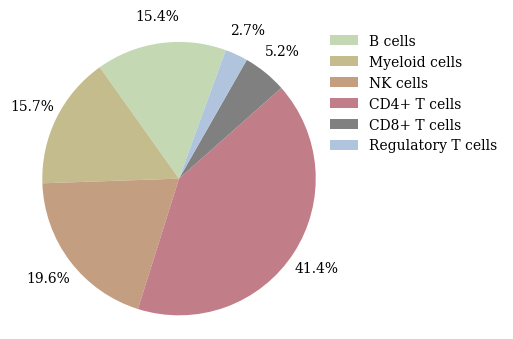

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(5, 3.5))  # Adjust the figure size as needed

ax.pie(
    [15.4, 15.7, 19.6, 41.4, 5.2, 2.7], autopct='%1.1f%%',
    startangle=70, colors=['#c4d9b3', '#c5bc8e', '#c49e81', '#c17d88', 'gray', 'lightsteelblue'], pctdistance=1.2,
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()


handles = []
for kk, label in enumerate(['B cells', 'Myeloid cells', 'NK cells', 'CD4+ T cells', 'CD8+ T cells', 'Regulatory T cells']):
    if index == 'sm_name':
        handles.append(Patch(facecolor=['blue', 'cyan'][kk], label=label))
    else:
        handles.append(Patch(facecolor=colors_cell_type[kk], label=label))

ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios_original.png', dpi=100, transparent=True)
plt.show()

In [ ]:
# merge T cells
sc_counts.obs['cell_type'] = sc_counts.obs['cell_type'].map(cell_type_map)
sc_counts.obs['cell_type'].unique()

array(['B cells', 'T cells', 'Myeloid cells', 'NK cells'], dtype=object)

In [ ]:
# simplify plate name
sc_counts.obs['plate_name'] = sc_counts.obs['plate_name'].astype(str).apply(lambda name: name.split('-')[1]).astype('category')
# group cell types per well
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')

## QC 

In [ ]:
sctk.default_metric_params_df

,min,max,scale,side,min_pass_rate
n_counts,1000.00,NaN,log,min_only,0.10
n_genes,100.00,NaN,log,min_only,0.10
percent_mito,0.01,20.0,log,max_only,0.10
percent_ribo,0.00,100.0,log,both,0.10
percent_hb,NaN,1.0,log,max_only,0.10
percent_soup,NaN,5.0,log,max_only,0.10
percent_spliced,50.00,97.5,log,both,0.10
scrublet_score,NaN,0.3,linear,max_only,0.95


### Cell wise

In [ ]:
def min_max(name, data):
    print(f'{name}: min:{data.min()}, max: {data.max()}')
min_max('n_counts', sc_counts.obs.n_counts)
min_max('n_genes', sc_counts.obs.n_genes)
min_max('percent_hb', sc_counts.obs.percent_hb)
min_max('percent_mito', sc_counts.obs.percent_mito)

n_counts: min:1947.0, max: 29992.0
n_genes: min:101, max: 6239
percent_hb: min:0.0, max: 95.78558943484171
percent_mito: min:0.025329280648429587, max: 20.068317677198973


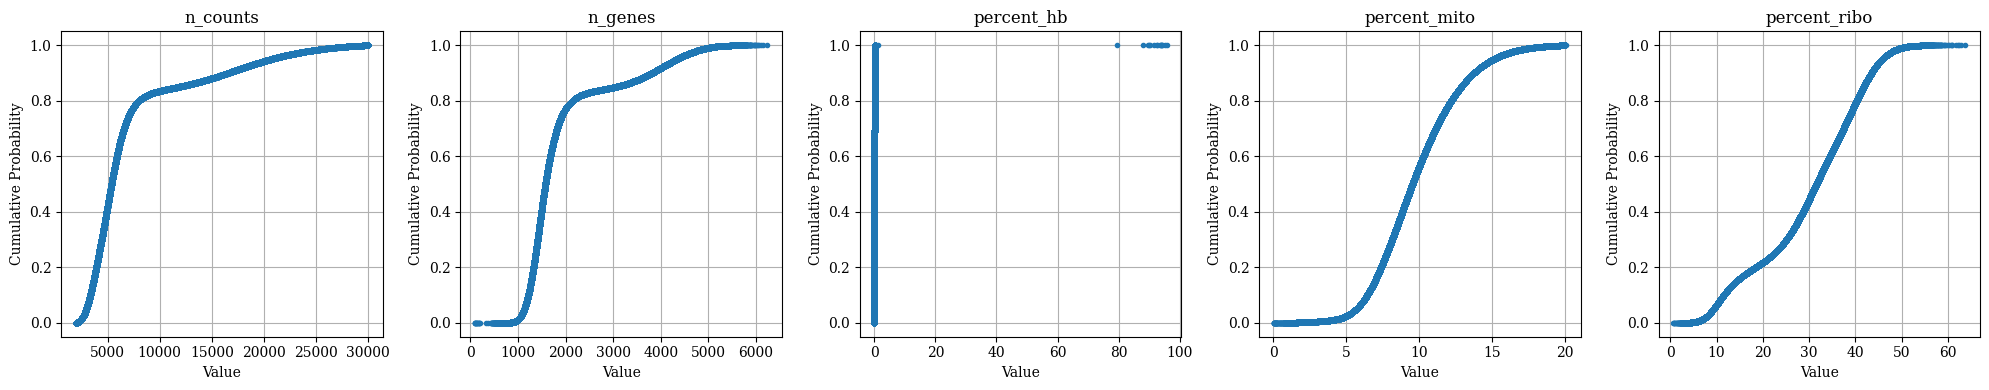

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(sc_counts.obs.n_counts, 'n_counts', axes[0])
plot_CDF(sc_counts.obs.n_genes, 'n_genes', axes[1])
plot_CDF(sc_counts.obs.percent_hb, 'percent_hb', axes[2])
plot_CDF(sc_counts.obs.percent_mito, 'percent_mito', axes[3])
plot_CDF(sc_counts.obs.percent_ribo, 'percent_ribo', axes[4])
plt.tight_layout()
plt.show()

In [ ]:
# for cells
print('n_counts:', sc_counts.obs.n_counts.min(), sc_counts.obs.n_counts.max())
print('n_genes:', sc_counts.obs.n_genes.min(), sc_counts.obs.n_genes.max())
print('percent_mito:', sc_counts.obs.percent_mito.min(), sc_counts.obs.percent_mito.max())
print('percent_ribo:', sc_counts.obs.percent_ribo.min(), sc_counts.obs.percent_ribo.max())
print('percent_hb:', sc_counts.obs.percent_hb.min(), sc_counts.obs.percent_hb.max())

n_counts: 1947.0 29992.0
n_genes: 101 6239
percent_mito: 0.025329280648429587 20.068317677198973
percent_ribo: 0.5988023952095809 63.80191274728154
percent_hb: 0.0 95.78558943484171


In [ ]:
filter_percent_hb = sc_counts.obs.percent_hb>.2
filter_percent_hb.sum()

20

### Gene wise

In [ ]:
plates = sc_counts.obs['plate_name'].unique()

# Step 2: Initialize a DataFrame to store counts
gene_counts_per_plate = pd.DataFrame(index=sc_counts.var_names, columns=plates, dtype=int)

# Step 3: Iterate over each plate and calculate expression counts
for plate in plates:
    # Subset the AnnData object for the current plate
    subset = sc_counts[sc_counts.obs['plate_name'] == plate]
    
    # Calculate expression counts (genes x cells > 0)
    expressed_genes = (subset.X > 0).sum(axis=0)
    
    # Check if the result needs conversion from sparse matrix format
    if isinstance(expressed_genes, np.matrix):
        expressed_genes = np.array(expressed_genes).flatten()
    
    # Store the counts in the DataFrame
    gene_counts_per_plate[plate] = expressed_genes

# Step 4: Aggregate counts across plates (max or sum based on the requirement)
# We use `max` here to find if any gene meets the criteria in at least one plate
max_counts = gene_counts_per_plate.max(axis=1)

# Step 5: Create a mask for genes to keep (genes expressed in at least 100 cells in any plate)
genes_to_keep = max_counts >= 100    

### Actual filtering

In [ ]:
sc_counts = sc_counts[(~filter_percent_hb), genes_to_keep]

In [ ]:
sc_counts.obs = sc_counts.obs[['cell_type', 'sm_name', 'donor_id', 'row', 'plate_name', 'well']]
sc_counts.var = sc_counts.var[[]]

del sc_counts.obsm
del sc_counts.uns

In [ ]:
sc_counts.write(f'{work_dir}/../input/sc_counts_f.h5ad')

# Pseudobulking counts 

In [ ]:
sc_counts= ad.read_h5ad(f'{work_dir}/../input/sc_counts_f.h5ad')

In [ ]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [ ]:
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')
# actuall bulking
bulk_adata = sum_by(sc_counts, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values
bulk_adata.X = np.array(bulk_adata.X.todense())

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

bulk_adata.var.set_index('index', inplace=True)

bulk_adata.write(f'{work_dir}/preprocess/bulk_adata.h5ad')

ratio of missingness 0.3868958551668455


# EDA on pseudobulked data and filtering

In [51]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')

sample_n = bulk_adata.shape[0]
gene_n = bulk_adata.shape[1]
obs_index= ['cell_type', 'sm_name']
# some preprocess
bulk_adata.X = np.nan_to_num(bulk_adata.X, nan=0)
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

## Gene missigness

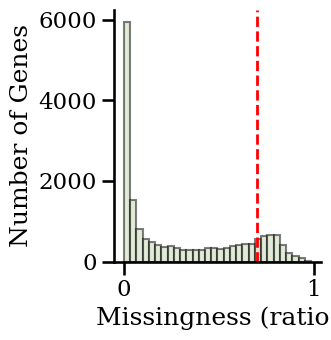

In [4]:
# Calculate missingness for each gene
missingness = (bulk_adata.X == 0).mean(axis=0)
missingness = np.array(missingness).flatten()

# Plot the distribution
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.hist(missingness, bins=30, color=colors_cell_type[0], edgecolor='black', alpha=0.5)
ax.axvline(x=0.7, color='red', linestyle='--', linewidth=2)  # Add a vertical line at 0.7
# ax.set_title('Distribution of Gene Missingness')
ax.set_xlabel('Missingness (ratio)')
ax.set_ylabel('Number of Genes')
ax.spines[['right', 'top']].set_visible(False)
ax.grid(False)

plt.tight_layout()

plt.show()

In [41]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.2971925668826342


## Initial clustering based on cell count and sum count

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

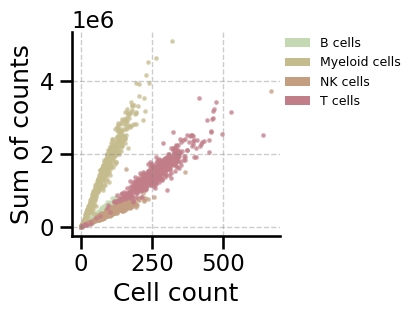

In [84]:
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5), sharey=False)

plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, x_label='Cell count', y_label='Sum of counts', log_x=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/eda1_cellcount_sumcounts_raw.png', dpi=150, transparent=True)

## Cell count distribution: compound based  

In [ ]:
outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
outliers_misbalance_donor_2 = ['Vorinostat']
outliers_misbalance_all = ['Proscillaridin A;Proscillaridin-A']
outliers_misbalance_donor_3 = ['AT13387', 'Ganetespib (STA-9090)']
outlier_compounds = outliers_toxic + outliers_two_celltype + outliers_misbalance_all + outliers_misbalance_donor_2 + outliers_misbalance_donor_3

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

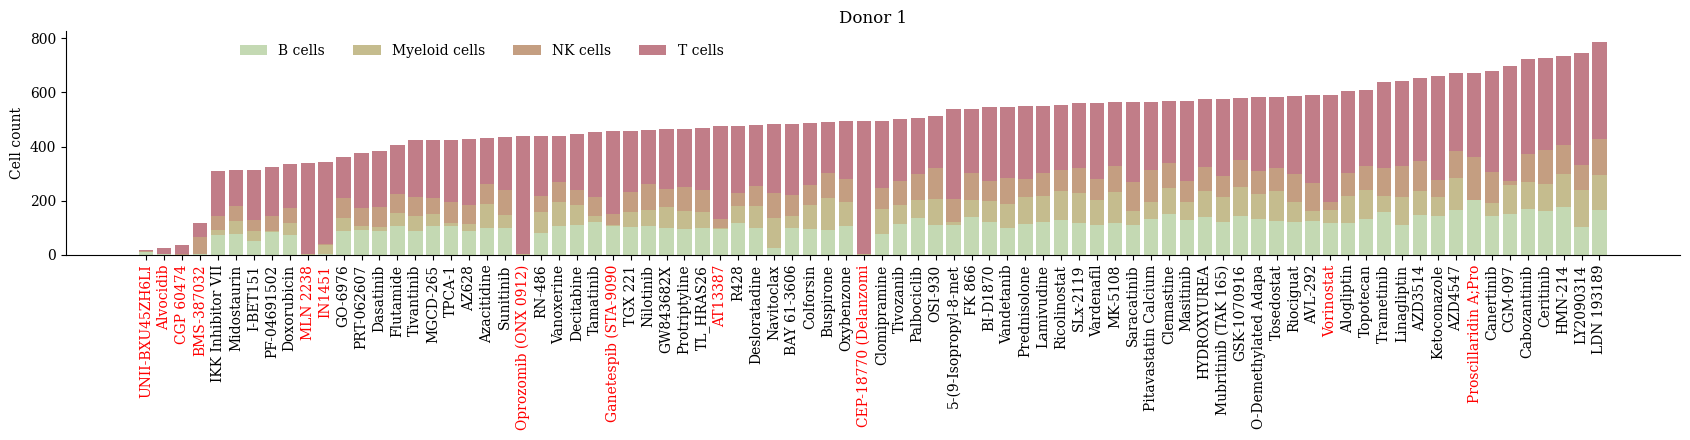

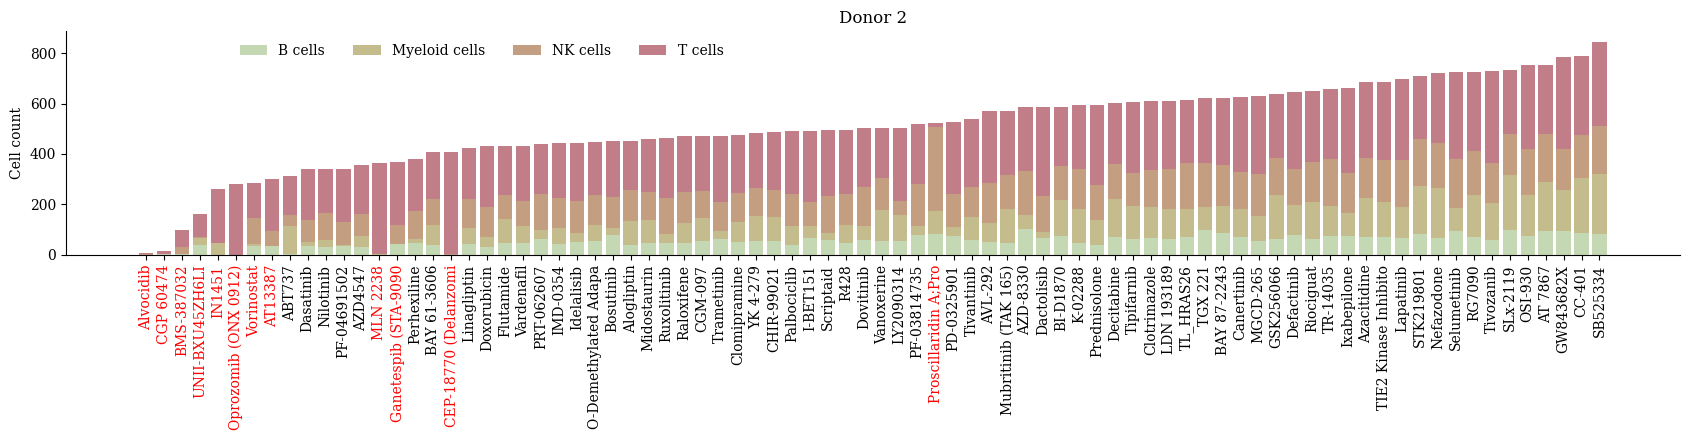

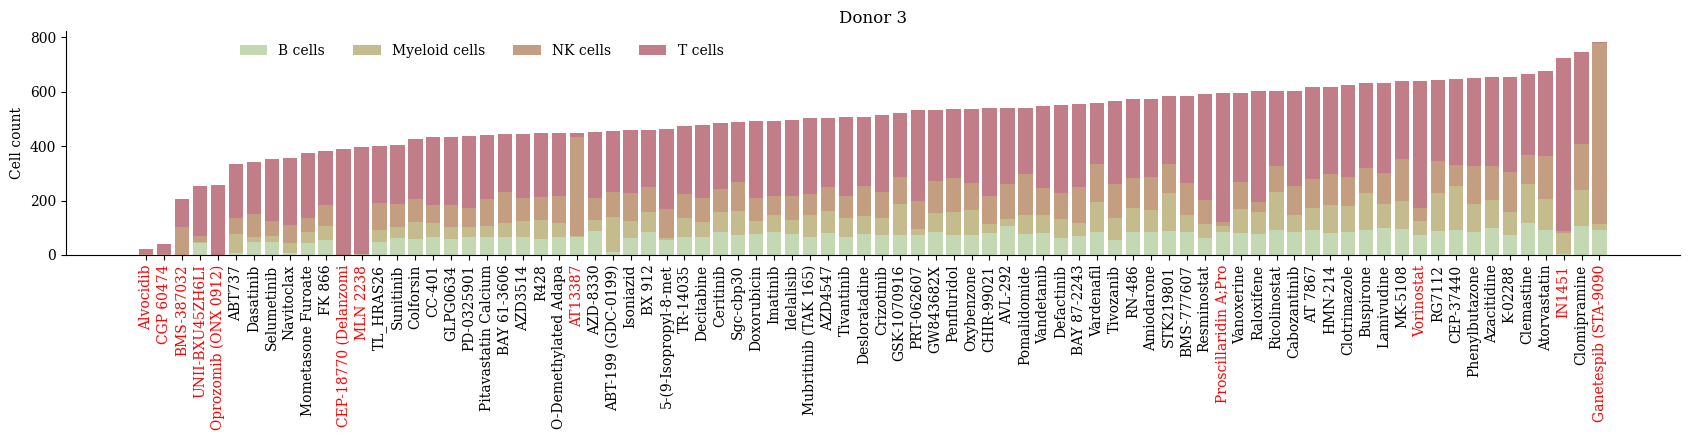

In [ ]:
bulk_adata_non_controls = bulk_adata[~bulk_adata.obs.sm_name.isin(controls3), :]
donor_ids = bulk_adata.obs.donor_id.unique()
outliers_list = []
for i_donor, donor_id in enumerate(donor_ids):
    # subset and format data
    df_subset = bulk_adata_non_controls.obs[bulk_adata_non_controls.obs.donor_id==donor_id][['sm_name', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)

    # outlier 
    outliers_if = isolation_forest(df_subset, group=['sm_name'])    
    outliers_list.append(outliers_if)
    
    # save the order
    # if i_donor==0:
    
    cell_count_m['sum'] = cell_count_m.sum(axis=1)
    cell_count_m = cell_count_m.sort_values('sum')
    cell_count_m = cell_count_m.drop(columns='sum')
    saved_order = cell_count_m.index
            
    # else:
    #     cell_count_m = cell_count_m.reindex(saved_order)

    colors = []
    masks = []
    for label in cell_count_m.index.values:
        if label in outlier_compounds:
            colors.append('red')
            mask = True
        else:
            colors.append('black')
            np.random.seed(32)
            mask = np.nan
        masks.append(mask)
    masks = np.asarray(masks)
    nan_mask = np.isnan(masks)
    random_bool = np.random.choice([True, False],size=nan_mask.sum())
    masks[nan_mask] = random_bool
    
    if True: # show only some of non outlier compounds
        cell_count_m['mask'] = masks
        cell_count_m['color'] = colors
        cell_count_m = cell_count_m[cell_count_m['mask']==True]
        colors = cell_count_m['color'].values
        cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
    # save the order
    
    xticklabels = cell_count_m.index.values
    xticklabels = [item[0:20] for item in xticklabels]
    fig, ax = plot_stacked_bar_chart(cell_count_m, title=donor_id, xticklabels=xticklabels, colors=colors, figsize=(17, 4.5))
    ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
    ax.set_ylabel('Cell count')
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    plt.tight_layout()
    fig.savefig(f'{work_dir}/preprocess/figs/outliers_{donor_id}.png', dpi=150, transparent=True)

all_outliers = np.unique(np.concatenate(outliers_list))
common_outliers = list(set(outliers_list[0]).intersection(outliers_list[1], outliers_list[2]))


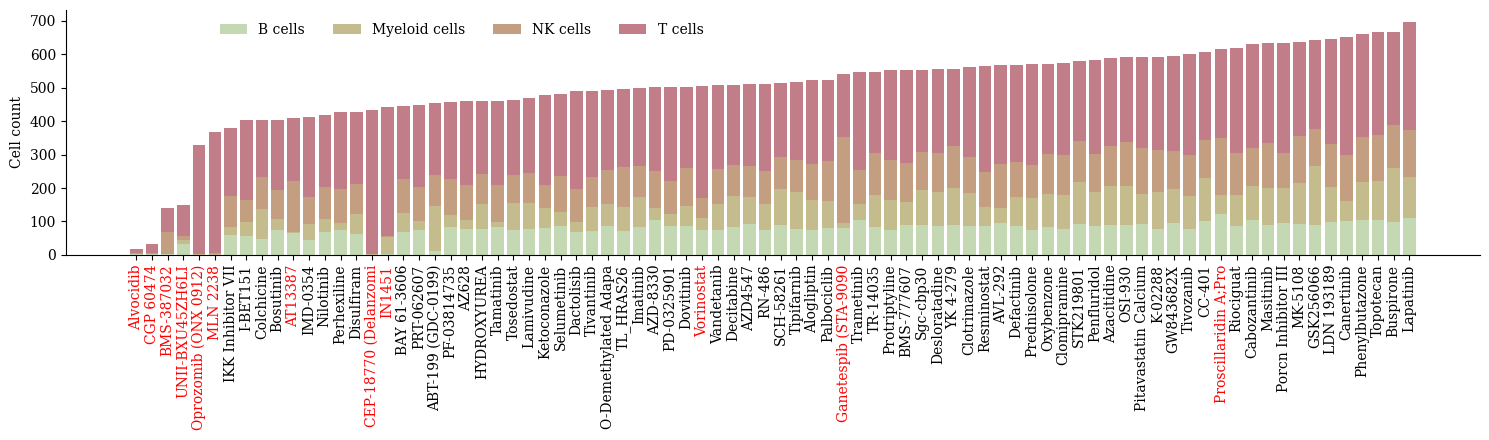

In [ ]:
# average across 
df_subset = bulk_adata_non_controls.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].mean()).to_frame().reset_index()
cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values=0)
cell_count_m = cell_count_m.fillna(0)

# save the order
cell_count_m['sum'] = cell_count_m.sum(axis=1)
cell_count_m = cell_count_m.sort_values('sum')
cell_count_m = cell_count_m.drop(columns='sum')
saved_order = cell_count_m.index

colors = []
masks = []
for label in cell_count_m.index.values:
    if label in outlier_compounds:
        colors.append('red')
        mask = True
    else:
        colors.append('black')
        np.random.seed(32)
        mask = np.nan
    masks.append(mask)
masks = np.asarray(masks)
nan_mask = np.isnan(masks)
random_bool = np.random.choice([True, False],size=nan_mask.sum())
masks[nan_mask] = random_bool

if True: # show only some of non outlier compounds
    cell_count_m['mask'] = masks
    cell_count_m['color'] = colors
    cell_count_m = cell_count_m[cell_count_m['mask']==True]
    colors = cell_count_m['color'].values
    cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
# save the order

xticklabels = cell_count_m.index.values
xticklabels = [item[0:20] for item in xticklabels]
fig, ax = plot_stacked_bar_chart(cell_count_m, title='', xticklabels=xticklabels, colors=colors, figsize=(15, 4.5))
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
ax.set_ylabel('Cell count')
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/outliers_mean.png', dpi=150, transparent=True)

In [ ]:
# samples with less than 10 cells
bulk_adata_filtered = bulk_adata.copy()
# toxic ones
outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(outliers_toxic),:]
# remove those with less than 10 cells left 
mask_low_cell_count = bulk_adata_filtered.obs.cell_count < 10
print(mask_low_cell_count.shape)
bulk_adata_filtered = bulk_adata_filtered[~mask_low_cell_count]
# remove those that have less than 2 cells types left per donor
to_go_compounds = []
for donor_id in bulk_adata_filtered.obs.donor_id.unique():
    adata_donor = bulk_adata_filtered[bulk_adata_filtered.obs.donor_id.eq(donor_id)]
    cell_type_n = adata_donor.obs.groupby('sm_name').size()
    to_go_compounds.append(cell_type_n[cell_type_n<=2].index.astype(str))
to_go_compounds = np.unique(np.concatenate(to_go_compounds))
outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
assert np.all(to_go_compounds==outliers_two_celltype)
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(to_go_compounds),:]

# remove big class misbalance in all donors 
outliers_misbalance_all = ['Proscillaridin A;Proscillaridin-A'] 
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_all),:]
# remove big class misbalance in 1 donor
outliers_misbalance_donor_2 = ['Vorinostat']
bulk_adata_filtered = bulk_adata_filtered[~ (bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_donor_2) & (bulk_adata_filtered.obs.donor_id=='Donor 2')),:]
outliers_misbalance_donor_3 = ['AT13387', 'Ganetespib (STA-9090)']
bulk_adata_filtered = bulk_adata_filtered[~ (bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_donor_3) & (bulk_adata_filtered.obs.donor_id=='Donor 3')),:]
 


bulk_adata_filtered

(2241,)


View of AnnData object with n_obs × n_vars = 2170 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

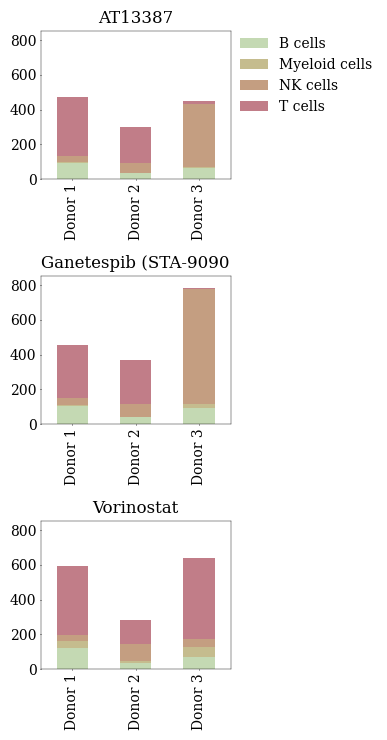

In [75]:
# group_to_plot = np.setdiff1d(all_outliers, common_outliers)
# group_to_plot = np.setdiff1d(common_outliers, included_outliers)
group_to_plot = ['AT13387', 'Ganetespib (STA-9090)', 'Vorinostat']

def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color, width=.5)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax

fig, axes = plt.subplots(3, 1, figsize=(4, 7.5))

ax_list = []
for i_compound, compound in enumerate(group_to_plot):
    ax = axes[i_compound]
    # subset and format data
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==compound][['donor_id', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='donor_id', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)
    
    ax.set_ylim([0, 850])
    plot_stacked_bar_chart(cell_count_m, title=compound[0:20], xticklabels=cell_count_m.index.values, colors=None, figsize=(4, 4), ax=ax, legend=False)
    ax_list.append(ax)
    ax.tick_params(axis='both', which='major', length=1, width=.5, direction='out', pad=2)
    ax.margins(.1)

ax_list[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)


plt.tight_layout()

## Missing counts

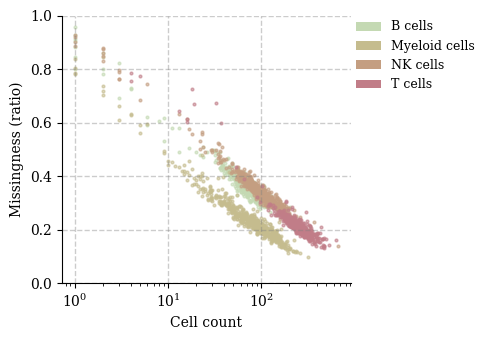

In [ ]:
missingness = (bulk_adata.X == 0).sum(axis=1)/bulk_adata.X.shape[1]
bulk_adata_df = pd.DataFrame(bulk_adata.X)

xs = bulk_adata.obs.cell_count
ys = missingness


fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey=False)

plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palet x_label='Cell count', y_label='Missingness (ratio)')
ax.set_ylim([0, 1])
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)


## Low gene coverage 

In [ ]:
mask_to_go_genes = ((bulk_adata_filtered.X == 0).sum(axis=0)/bulk_adata_filtered.shape[0])>0.7
mask_to_go_genes.sum()

3033

In [ ]:
bulk_adata_filtered = bulk_adata_filtered[:,~mask_to_go_genes] 
bulk_adata_filtered

View of AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

In [ ]:
bulk_adata_filtered.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

In [ ]:
bulk_adata_filtered.obs.sm_name.unique().shape

(138,)

## Highly variable genes

In [ ]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [ ]:
n_hvgs = 3000

In [ ]:
%%R  -i work_dir # run this from terminal 
library(scry)
library(zellkonverter)
library(SingleCellExperiment)

work_dir = './output'
adata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
sce = scry::devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    

RInterpreterError: Failed to parse and evaluate line '# run this from terminallibrary(scry)\nlibrary(zellkonverter)\nlibrary(SingleCellExperiment)\n\nwork_dir = \'./output\'\nadata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts\nsce = scry::devianceFeatureSelection(adata, assay="X")\nwriteH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))\n'.
R error message: "Error in py_call_impl(callable, call_args$unnamed, call_args$named) : \n  FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/preprocess/bulk_adata_f.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)\nRun `reticulate::py_last_error()` for details."
R stdout:
Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomeInfoDb
Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Attaching package: ‘Biobase’

The following object is masked from ‘package:MatrixGenerics’:

    rowMedians

The following objects are masked from ‘package:matrixStats’:

    anyMissing, rowMedians

Error in py_call_impl(callable, call_args$unnamed, call_args$named) : 
  FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './output/preprocess/bulk_adata_f.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Run `reticulate::py_last_error()` for details.
In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: Python '/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/bin/python' was requested but '/root/anaconda3/envs/py10/bin/python' was loaded instead (see reticulate::py_config() for more information)

In [ ]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

In [ ]:
# hvg vs sum 
genes = hvgs_sce
adata_f = bulk_adata
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = adata_f.var
var['sum'] = adata_f.X.sum(axis=0)
var['std'] = adata_f.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')


ax.set_ylabel('Std across samples')
ax.set_xlabel('Sum across samples')
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

In [ ]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
all_genes = bulk_adata.var.index.values
mask_hkgs = bulk_adata.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]
non_hkgs.shape

(11702,)

In [ ]:
hvgs = hvgs_sce
genesets_dict = {'HKGs':housekeeping_genes, 'Rest': non_hkgs}
hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {} # top percentile score versus randomly selected genes with the same dimension
n_random = 1000
for name, geneset in genesets_dict.items():
    shared_genes = np.intersect1d(geneset, all_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(all_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
print(f'{hvgs_intersection_ratio_dict=} \n {top_p_dict=}')

hvgs_intersection_ratio_dict={'HKGs': 0.18445772843723313, 'Rest': 0.200991283541275} 
 top_p_dict={'HKGs': 0.705, 'Rest': 0.007}


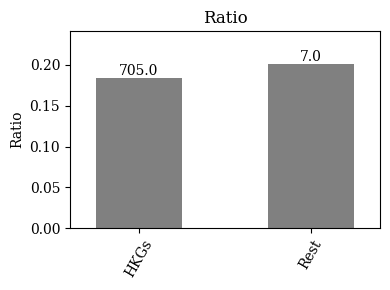

In [ ]:
hvgs = hvgs_sce

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)

def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color='grey')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(ax,  hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

plt.tight_layout()
plt.show()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

# Batch effect correction


In [4]:
if False:
    bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
    bulk_adata.obs['positive_control'] = bulk_adata.obs.sm_name.isin(controls2)
else:
    bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')
    bulk_adata.obs['positive_control'] = bulk_adata.obs.sm_name.isin(controls2)


In [7]:
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type', 'positive_control'
    layers: 'counts', 'lognorm', 'n_counts', 'pearson', 'seurat_lognorm', 'seurat_pearson'

## Normalize with respect to cell counts
Considering that we have class imbalance with respect to cell counts, we normalize the raw values considering associated cell counts. This is similar to pseuudobulking using mean.

In [11]:
bulk_adata.X = bulk_adata.layers['counts'].copy()
rows_adj = []
for i, row in enumerate(bulk_adata.X):
    count = bulk_adata.obs.cell_count[i]
    rows_adj.append(row/count)

bulk_adata.layers['n_counts'] = np.asarray(rows_adj)

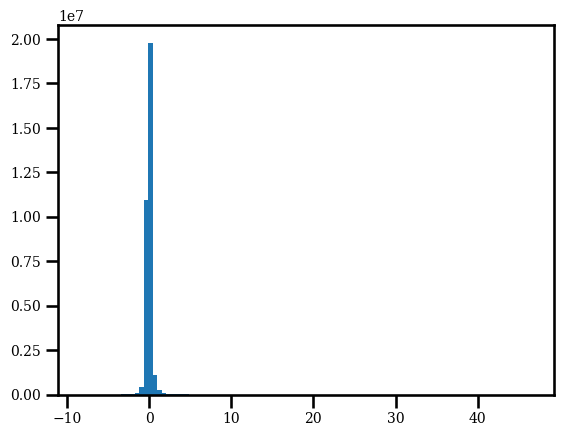

In [136]:
aa = plt.hist(bulk_adata.layers['pearson'].flatten(), bins=100)

## Normalization

In [128]:
# normalize data based on sum pseudobulk
bulk_adata.X = bulk_adata.layers['counts']

bulk_adata_c = bulk_adata.copy()
sc.experimental.pp.normalize_pearson_residuals(bulk_adata_c)
bulk_adata.layers['pearson_sum'] = bulk_adata_c.X

bulk_adata_c = bulk_adata.copy()
sc.pp.normalize_total(bulk_adata_c)
sc.pp.log1p(bulk_adata_c)
sc.pp.scale(bulk_adata_c)
bulk_adata.layers['lognorm_sum'] = bulk_adata_c.X

In [13]:
# normalize data based on mean pseudobulk
bulk_adata.X = bulk_adata.layers['n_counts']

bulk_adata_c = bulk_adata.copy()
sc.experimental.pp.normalize_pearson_residuals(bulk_adata_c)
bulk_adata.layers['pearson'] = bulk_adata_c.X

bulk_adata_c = bulk_adata.copy()
sc.pp.normalize_total(bulk_adata_c)
sc.pp.log1p(bulk_adata_c)
sc.pp.scale(bulk_adata_c)
bulk_adata.layers['lognorm'] = bulk_adata_c.X

In [15]:
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')

In [19]:
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type', 'positive_control'
    layers: 'counts', 'n_counts', 'pearson', 'lognorm'

## Linear embedding integration using Mutual Nearest Neighbors (MNN):seurat
we run this code once with lognorm and once with pearson normalization data.

In [4]:
norm_name = 'pearson'

In [5]:
adata_seurat = bulk_adata.copy()
# Convert categorical columns to strings
adata_seurat.obs[batch_key] = adata_seurat.obs[batch_key].astype(str)
adata_seurat.obs[label_key] = adata_seurat.obs[label_key].astype(str)
# Delete uns as this can contain arbitrary objects which are difficult to convert
del adata_seurat.uns

adata_seurat

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type', 'positive_control'
    layers: 'counts', 'lognorm', 'n_counts', 'pearson', 'seurat_lognorm'

In [6]:

%%R -i adata_seurat -i norm_name
library(Seurat)

seurat <- as.Seurat(adata_seurat, counts = "counts", data = norm_name)
seurat


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    An object of class Seurat 
15215 features across 2170 samples within 1 assay 
Active assay: originalexp (15215 features, 0 variable features)
 2 layers present: counts, data


Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘sp’

The following object is masked from ‘package:IRanges’:

    %over%

‘SeuratObject’ was built under R 4.1.2 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed
‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

The following object is masked from ‘package:GenomicRanges’:

    intersect

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following object is masked from ‘package:IRanges’:

    intersect

The following object is masked from ‘package:S4Vectors’:

    intersect

The following object is masked from ‘package:BiocGenerics’:

    intersect

The followi

In [7]:
%%R -i batch_key
batch_list <- SplitObject(seurat, split.by = batch_key)
batch_list

$`010`
An object of class Seurat 
15215 features across 353 samples within 1 assay 
Active assay: originalexp (15215 features, 0 variable features)
 2 layers present: counts, data

$`011`
An object of class Seurat 
15215 features across 374 samples within 1 assay 
Active assay: originalexp (15215 features, 0 variable features)
 2 layers present: counts, data

$`012`
An object of class Seurat 
15215 features across 348 samples within 1 assay 
Active assay: originalexp (15215 features, 0 variable features)
 2 layers present: counts, data

$`013`
An object of class Seurat 
15215 features across 375 samples within 1 assay 
Active assay: originalexp (15215 features, 0 variable features)
 2 layers present: counts, data

$`014`
An object of class Seurat 
15215 features across 346 samples within 1 assay 
Active assay: originalexp (15215 features, 0 variable features)
 2 layers present: counts, data

$`015`
An object of class Seurat 
15215 features across 374 samples within 1 assay 
Active assa

In [8]:
%%R
anchors <- FindIntegrationAnchors(batch_list, anchor.features = rownames(seurat))
anchors

  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~02s           |+++++++++++++++++                                 | 33% ~02s           |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~calculating   |++++                                              | 7 % ~01m 02s       |+++++++                                           | 13% ~59s           |++++++++++                                        | 20% ~55s           |++++++++++++++                                    | 27% ~49s           |+++++++++++++++++                                 | 33% ~44s           |++++++++++++++++++++                              | 40% ~40

Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1272 anchors
Filtering anchors
	Retained 1259 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1192 anchors
Filtering anchors
	Retained 1177 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1272 anchors
Filtering anchors
	Retained 1244 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1248 anchors
Filtering anchors
	Retained 1232 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1303 anchors
Filtering anchors
	Retained 1297 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1280 anchors
Filtering anchors
	Retained 1261 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 1233 anchors
Filtering anchors
	Retained 1225 anchors
Running CCA
Merging objects
Finding neighbor

In [9]:
%%R
integrated <- IntegrateData(anchors)
integrated

An object of class Seurat 
30430 features across 2170 samples within 2 assays 
Active assay: integrated (15215 features, 15215 variable features)
 1 layer present: data
 1 other assay present: originalexp


Merging dataset 5 into 6
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 3 into 4
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 1 into 2
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 6 5 into 2 1
Extracting anchors for merged samples
Finding integration vectors

In [10]:
%%R -o integrated_expr
# Extract the integrated expression matrix
integrated_expr <- GetAssayData(integrated)
# Make sure the rows and columns are in the same order as the original object
integrated_expr <- integrated_expr[rownames(seurat), colnames(seurat)]
# Transpose the matrix to AnnData format
integrated_expr <- t(integrated_expr)

In [11]:
bulk_adata.layers[f'seurat_{norm_name}'] = np.asarray(integrated_expr.todense())

In [12]:
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')

In [13]:
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type', 'positive_control'
    layers: 'counts', 'lognorm', 'n_counts', 'pearson', 'seurat_lognorm', 'seurat_pearson'

In [14]:
aaaa

NameError: name 'aaaa' is not defined

## scGEN

In [12]:
import scgen

norm_name = 'lognorm'
train = bulk_adata.copy()
train.X = train.layers[norm_name]
sc.pp.neighbors(train)
sc.tl.umap(train)

In [13]:
scgen.SCGEN.setup_anndata(train, batch_key=batch_key, labels_key=label_key)
model = scgen.SCGEN(train)
model.train(
    max_epochs=100,
    batch_size=64,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 58/100:  58%|█████▊    | 58/100 [00:46<00:33,  1.25it/s, v_num=1, train_loss_step=4.12e+3, train_loss_epoch=4.05e+3]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 9441.539. Signaling Trainer to stop.


In [14]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type', 'positive_control', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

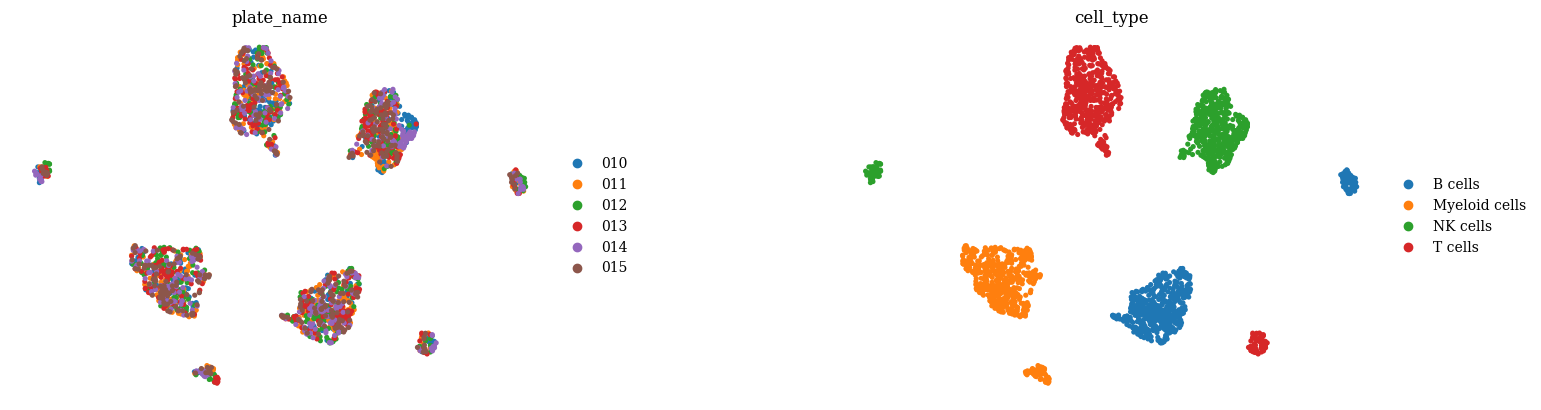

In [15]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=[batch_key, label_key], wspace=0.4, frameon=False)

In [16]:
bulk_adata.layers[f'scgen_{norm_name}'] = corrected_adata.X

In [17]:
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')

In [20]:
bulk_adata_c = bulk_adata.copy()

# Evaluation of data 

In [3]:
method_names = ['n_counts', 'lognorm', 'pearson', 'seurat_lognorm', 'seurat_pearson', 'scgen_lognorm', 'scgen_pearson']

In [4]:
bulk_adata = ad.read(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type', 'positive_control'
    layers: 'counts', 'lognorm', 'n_counts', 'pearson', 'scgen_lognorm', 'scgen_pearson', 'seurat_lognorm', 'seurat_pearson'

## Sparsity

In [ ]:
for method_name in method_names:
    print(method_name, np.count_nonzero(bulk_adata.layers[method_name].flatten())/bulk_adata.X.size)

counts 0.8165768379797405
lognorm 1.0
pearson 1.0
seurat 1.0
seurat_pearson 1.0
scgen 1.0
scgen_pearson 1.0


## Percentile rank

In [18]:
def calculate_percentile_rank(bulk_adata_c, mask_group:list[bool]) -> dict[str, float]:
    '''
        Calculate ranks of the group with the given True values in the mask_group to 1000 random selection of same size by 
        taking sum of top quantile values. 
    '''
    # stats
    n_occurance = (mask_group).sum()
    n_samples = len(bulk_adata_c)
    p=[n_occurance/n_samples,  (n_samples-n_occurance)/n_samples]
    # make all expression positive
    X = bulk_adata_c.X
    X += np.abs(np.min(np.min(X)))

    qr_scores = []
    for tt in np.linspace(0.9, .99, 10):
        quantile_per_gene = np.quantile(X, tt, axis=0)
        top_qq_sum = []
        for i_row, row in enumerate(X):
            top_qq_sum.append((row>quantile_per_gene).sum())
        top_qq_sum = np.asarray(top_qq_sum)
              

        # mask the group
        top_qq_ctr_sum = top_qq_sum[mask_group].sum()
        # mask random
        top_qq_random_sum_list = []
        for i in range(1000):
            mask = np.random.choice([True, False], n_samples, p=p)
            top_qq_random_sum_list.append(top_qq_sum[mask].sum())
        score = round(((top_qq_random_sum_list>top_qq_ctr_sum).sum()/1000)*100, 3)        
        qr_scores.append(score)
    
    return np.mean(qr_scores)

def run_metrics(adata, name):
    """
        Calculates percentile rank for each cell type and positive control.
    """
    adata_int = adata.copy()
    scores_all = {}
    # cell type
    for cell_type in adata_int.obs['cell_type'].unique():
        mask = adata_int.obs['cell_type'] == cell_type
        scores_all[cell_type] = [calculate_percentile_rank(adata_int, mask)]


    # positive control
    mask = adata_int.obs['positive_control']
    scores_all['positive_control_1'] = [calculate_percentile_rank(adata_int, mask)]
    mask = ~adata_int.obs['positive_control']
    scores_all['positive_control_0'] = [calculate_percentile_rank(adata_int, mask)]
    metrics_df = pd.DataFrame(scores_all)
    metrics_df.index = [name]

    return metrics_df

for i_method, method_name in enumerate(['counts'] + method_names):
# for i_method, method_name in enumerate(['pearson','lognorm']):
    # print('\n ', method_name)
    bulk_adata_c = bulk_adata.copy()
    bulk_adata_c.X = bulk_adata_c.layers[f'{method_name}']

    metrics_df = run_metrics(bulk_adata_c, method_name)
    print(metrics_df)

    if i_method == 0:
        rr_all_local = metrics_df.copy()
    else:
        rr_all_local = pd.concat([rr_all_local, metrics_df], axis=0)

    # rr_all_local = pd.concat([rr_all_local, metrics_df], axis=0)

In [18]:
rr_all_local = rr_all_local.round(1)

In [13]:
rr_all_local.to_csv(f'{work_dir}/preprocess/batch_correction/scores_local.csv')

In [24]:
rr_all_local = pd.read_csv(f'{work_dir}/preprocess/batch_correction/scores_local.csv', index_col=0)
rr_all_local

,B cells,Myeloid cells,NK cells,T cells,positive_control_1,positive_control_0
counts,100.00,0.00,100.00,1.15,3.50,96.66
n_counts,100.00,0.00,100.00,100.00,2.46,97.61
lognorm,63.89,0.29,0.00,100.00,4.60,95.51
pearson,98.19,0.00,23.39,100.00,1.29,98.66
seurat_lognorm,48.60,0.67,0.00,100.00,2.68,97.66
seurat_pearson,95.60,0.00,4.11,100.00,0.72,99.63
scgen_lognorm,100.00,0.00,0.00,100.00,0.02,99.97
scgen_pearson,99.98,0.00,90.73,100.00,0.05,99.94


## Pseudobulked: mean vs sum 

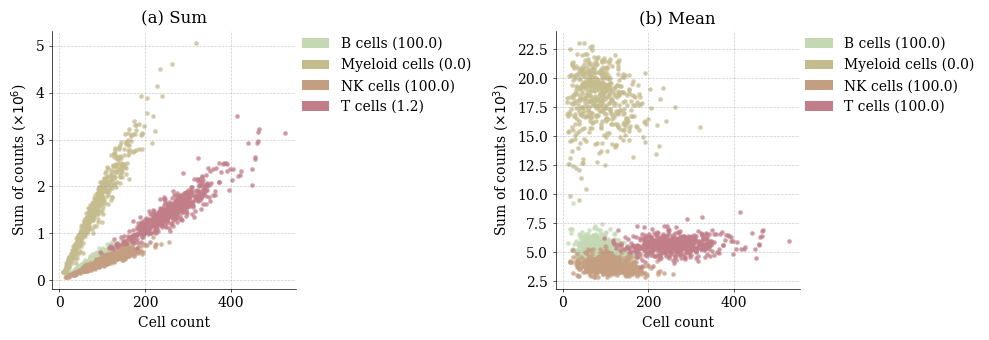

In [19]:
# cell type 
from local_utils import plots
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

# sum
method = 'counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.sum(axis=1)

rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()
rr_all_positivecontrol = {1:rr_all_local.loc[method, 'positive_control_1'], 0:rr_all_local.loc[method, 'positive_control_0']}

ys = ys/1E6 
ax = axes[0]
bbox_to_anchor = (1,1)

plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, bbox_to_anchor=bbox_to_anchor,palette=colors_cell_type, x_label='Cell count', y_label='Sum of counts ($\\times 10^6$)', extra_labels=rr_all_celltypes)
ax.set_title('(a) Sum')

# mean 
method = 'n_counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.sum(axis=1)

rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()
rr_all_positivecontrol = {1:rr_all_local.loc[method, 'positive_control_1'], 0:rr_all_local.loc[method, 'positive_control_0']}

ys = ys/1E3 
bbox_to_anchor = (1, 1)
ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,bbox_to_anchor=bbox_to_anchor, palette=colors_cell_type, x_label='Cell count', y_label='Sum of counts ($\\times 10^3$)', extra_labels=rr_all_celltypes)
ax.set_title('(b) Mean')

plt.tight_layout()


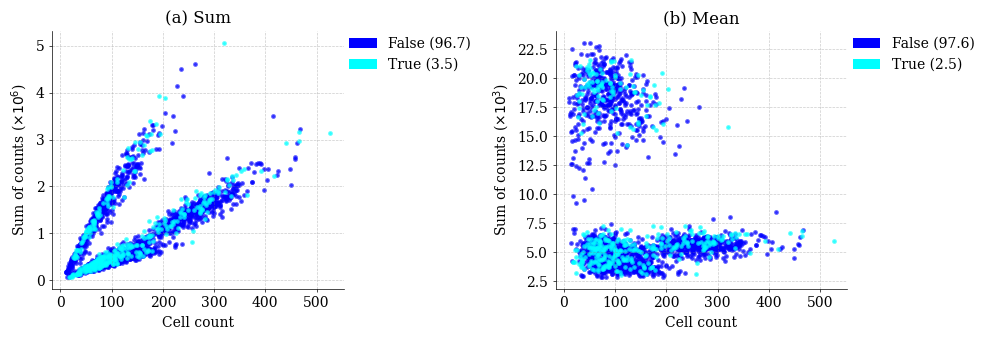

In [20]:
# positive control
from local_utils import plots
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

# sum
method = 'counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.sum(axis=1)

rr_all_positivecontrol = {1:rr_all_local.loc[method, 'positive_control_1'], 0:rr_all_local.loc[method, 'positive_control_0']}

ys = ys/1E6 
ax = axes[0]
bbox_to_anchor = (1, 1)


plots.plot_stratified_scatter(bulk_adata.obs['positive_control'], ax, xs, ys, bbox_to_anchor=bbox_to_anchor,palette=colors_positive_controls, x_label='Cell count', y_label='Sum of counts ($\\times 10^6$)', extra_labels=rr_all_positivecontrol)
ax.set_title('(a) Sum')

# mean 
method = 'n_counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.sum(axis=1)

rr_all_positivecontrol = {1:rr_all_local.loc[method, 'positive_control_1'], 0:rr_all_local.loc[method, 'positive_control_0']}

ys = ys/1E3 
ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['positive_control'], ax, xs, ys,bbox_to_anchor=bbox_to_anchor, palette=colors_positive_controls, x_label='Cell count', y_label='Sum of counts ($\\times 10^3$)', extra_labels=rr_all_positivecontrol)
ax.set_title('(b) Mean')

plt.tight_layout()


## Pseudobulked: std vs cell count 

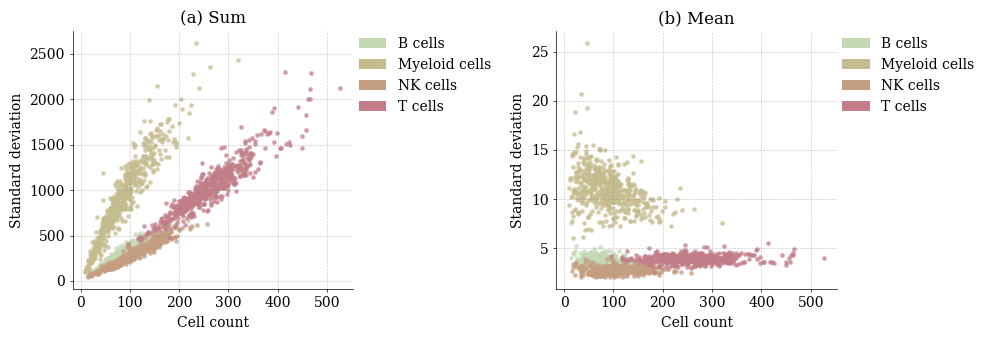

In [305]:
# cell type 
from local_utils import plots
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

# sum
method = 'counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.std(axis=1)

ax = axes[0]
bbox_to_anchor = (1,1)

plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, bbox_to_anchor=bbox_to_anchor,palette=colors_cell_type, x_label='Cell count', y_label='Standard deviation')
ax.set_title('(a) Sum')

# mean 
method = 'n_counts'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.obs.cell_count
ys = bulk_adata.X.std(axis=1)

bbox_to_anchor = (1, 1)
ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,bbox_to_anchor=bbox_to_anchor, palette=colors_cell_type, x_label='Cell count', y_label='Standard deviation')
ax.set_title('(b) Mean')

plt.tight_layout()


## Normalization: std vs sum of normalized data 

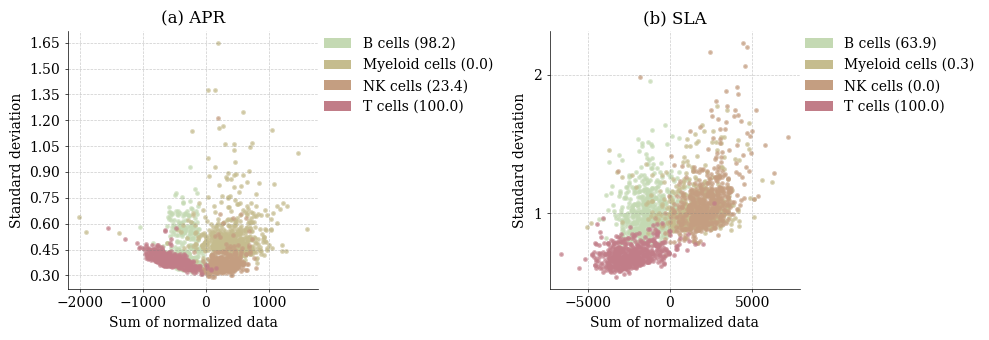

In [21]:
# APR
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

method = 'pearson'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)

# get the percentile rank
rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()

ax = axes[0]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type,x_label='Sum of normalized data', y_label='Standard deviation', extra_labels=rr_all_celltypes)
ax.set_title('(a) APR')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


method = 'lognorm'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)
rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()

ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,palette=colors_cell_type, x_label='Sum of normalized data', y_label='Standard deviation', extra_labels=rr_all_celltypes)
ax.set_title('(b) SLA')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()

## Batch corrected: std vs sum of normalized data 

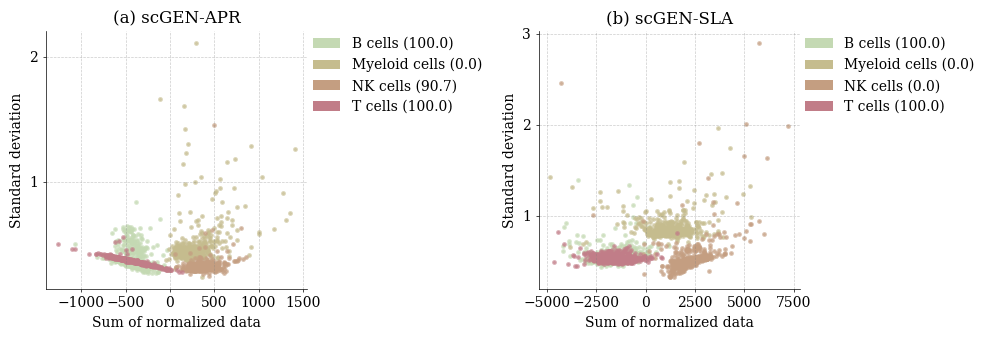

In [22]:
# APR
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

method = 'scgen_pearson'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)

# get the percentile rank
rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()

ax = axes[0]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type,x_label='Sum of normalized data', y_label='Standard deviation', extra_labels=rr_all_celltypes)
ax.set_title('(a) scGEN-APR')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


method = 'scgen_lognorm'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)
rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()

ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,palette=colors_cell_type, x_label='Sum of normalized data', y_label='Standard deviation', extra_labels=rr_all_celltypes)
ax.set_title('(b) scGEN-SLA')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()

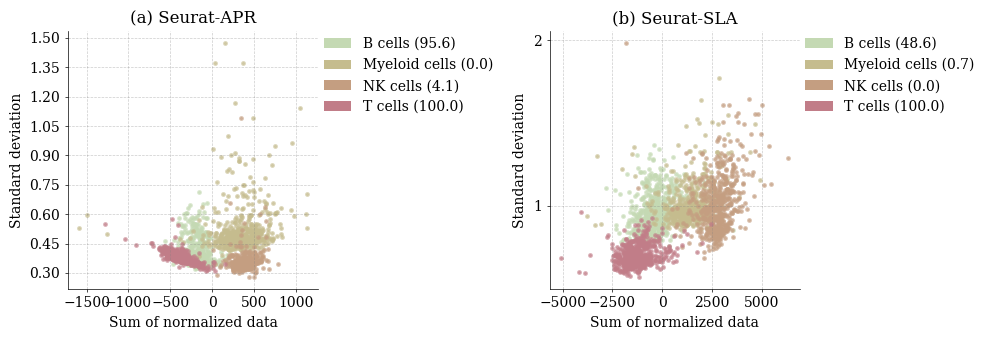

In [23]:
# APR
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=False)

method = 'seurat_pearson'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)

# get the percentile rank
rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()

ax = axes[0]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys, palette=colors_cell_type,x_label='Sum of normalized data', y_label='Standard deviation', extra_labels=rr_all_celltypes)
ax.set_title('(a) Seurat-APR')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


method = 'seurat_lognorm'
bulk_adata.X = bulk_adata.layers[method]
xs = bulk_adata.X.sum(axis=1)
ys = bulk_adata.X.std(axis=1)
rr_all_celltypes = rr_all_local.loc[method, cell_types].to_dict()

ax = axes[1]
plots.plot_stratified_scatter(bulk_adata.obs['cell_type'], ax, xs, ys,palette=colors_cell_type, x_label='Sum of normalized data', y_label='Standard deviation', extra_labels=rr_all_celltypes)
ax.set_title('(b) Seurat-SLA')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()

## UMAP

In [325]:
# normalized pearson
bulk_adata_c = bulk_adata.copy()
bulk_adata_c.X = bulk_adata_c.layers['pearson']
sc.pp.neighbors(bulk_adata_c)
sc.tl.leiden(bulk_adata_c, resolution=.5)
sc.tl.umap(bulk_adata_c)


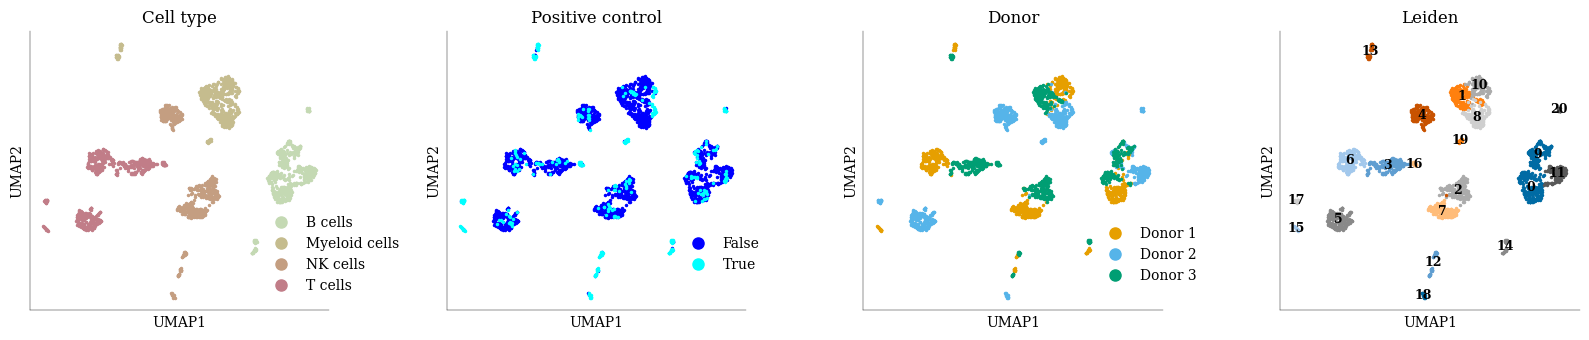

In [328]:
from local_utils import plots
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=False)
bbox_to_anchor = (.75, .2)
ax = axes[0]
plots.plot_umap(bulk_adata_c, color='cell_type', palette=colors_cell_type, ax=ax, bbox_to_anchor=bbox_to_anchor)
ax.set_title('Cell type')

ax = axes[1]
plots.plot_umap(bulk_adata_c, color='positive_control', palette=colors_positive_controls, ax=ax, bbox_to_anchor=bbox_to_anchor)
ax.set_title('Positive control')

ax = axes[2]

plots.plot_umap(bulk_adata_c, color='donor_id', palette=colors_blind, ax=ax, bbox_to_anchor=bbox_to_anchor)
ax.set_title('Donor')

ax = axes[3]

plots.plot_umap(bulk_adata_c, color='leiden',  ax=ax, bbox_to_anchor=bbox_to_anchor, legend=False)
ax.set_title('Leiden')

plt.tight_layout()

In [314]:
# normalized SLA
bulk_adata_c = bulk_adata.copy()
bulk_adata_c.X = bulk_adata_c.layers['lognorm']
sc.pp.neighbors(bulk_adata_c)
sc.tl.leiden(bulk_adata_c, resolution=.5)
sc.tl.umap(bulk_adata_c)

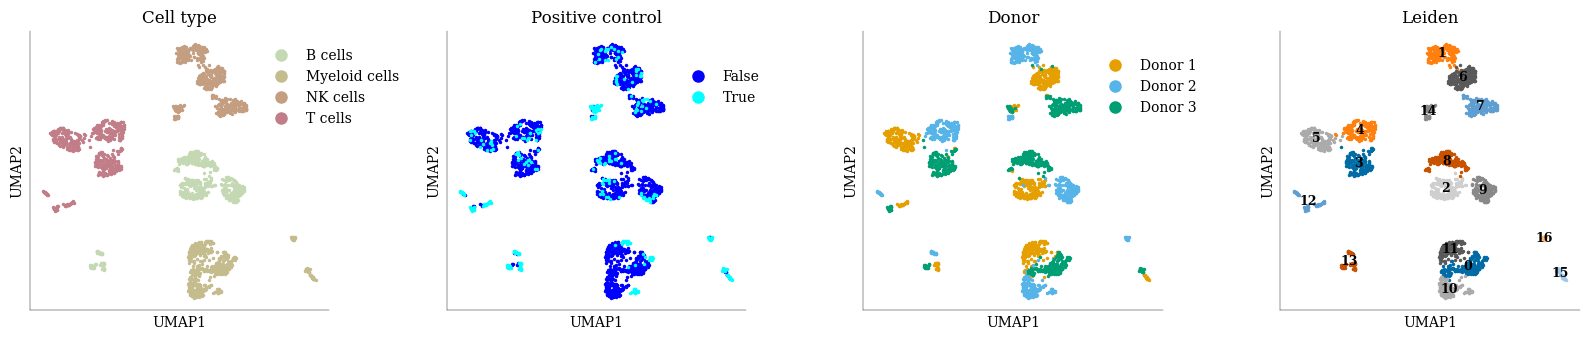

In [324]:
from local_utils import plots
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=False)
bbox_to_anchor = (.75, .8)
ax = axes[0]
plots.plot_umap(bulk_adata_c, color='cell_type', palette=colors_cell_type, ax=ax, bbox_to_anchor=bbox_to_anchor)
ax.set_title('Cell type')

ax = axes[1]
plots.plot_umap(bulk_adata_c, color='positive_control', palette=colors_positive_controls, ax=ax, bbox_to_anchor=bbox_to_anchor)
ax.set_title('Positive control')

ax = axes[2]

plots.plot_umap(bulk_adata_c, color='donor_id', palette=colors_blind, ax=ax, bbox_to_anchor=bbox_to_anchor)
ax.set_title('Donor')

ax = axes[3]

plots.plot_umap(bulk_adata_c, color='leiden',  ax=ax, bbox_to_anchor=bbox_to_anchor, legend=False)
ax.set_title('Leiden')

plt.tight_layout()

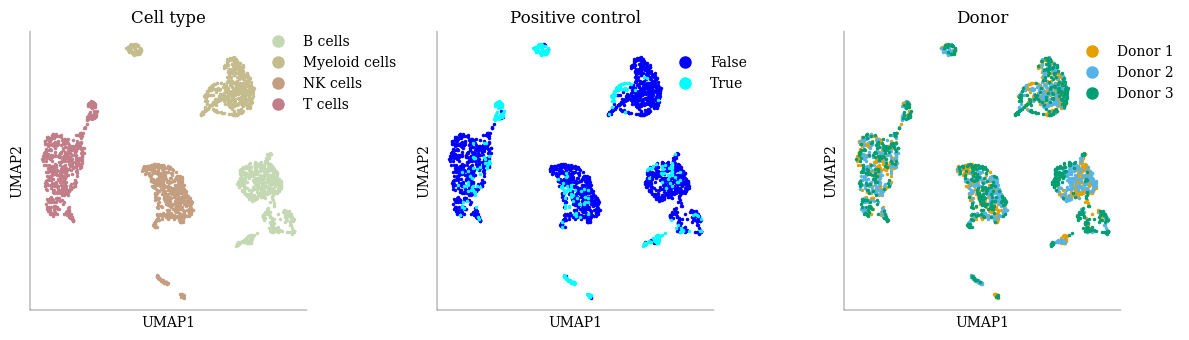

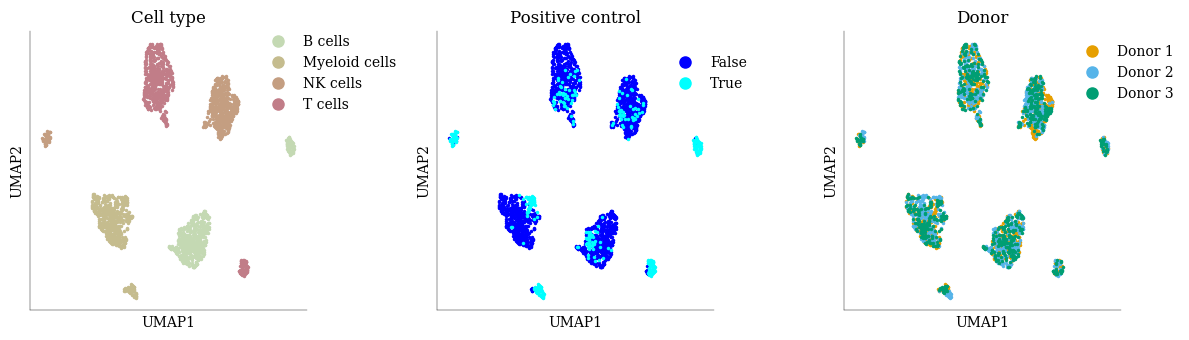

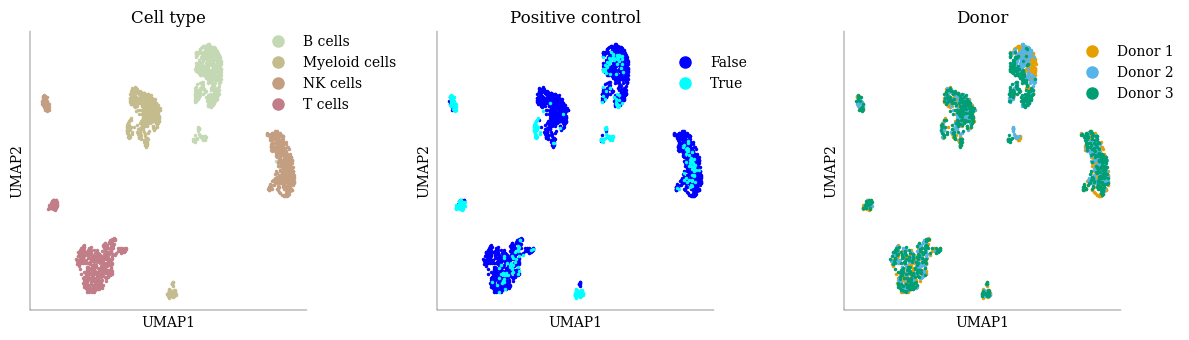

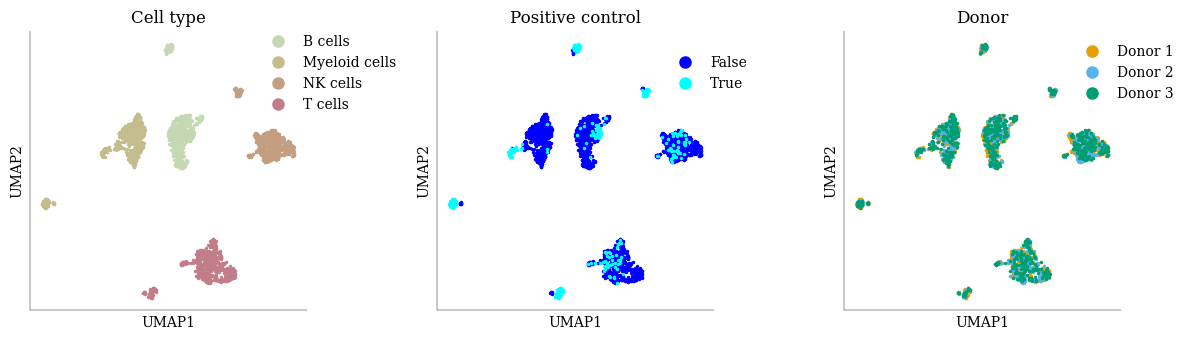

In [329]:
# normalized pearson corrected
from local_utils import plots
for method in ['scgen_pearson', 'scgen_lognorm', 'seurat_pearson', 'seurat_lognorm']:
    bulk_adata_c = bulk_adata.copy()
    bulk_adata_c.X = bulk_adata_c.layers[method]
    sc.pp.neighbors(bulk_adata_c)
    sc.tl.leiden(bulk_adata_c, resolution=.5)
    sc.tl.umap(bulk_adata_c)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=False)
    bbox_to_anchor = (.8, .85)
    ax = axes[0]
    plots.plot_umap(bulk_adata_c, color='cell_type', palette=colors_cell_type, ax=ax, bbox_to_anchor=bbox_to_anchor)
    ax.set_title('Cell type')

    ax = axes[1]
    plots.plot_umap(bulk_adata_c, color='positive_control', palette=colors_positive_controls, ax=ax, bbox_to_anchor=bbox_to_anchor)
    ax.set_title('Positive control')

    ax = axes[2]

    plots.plot_umap(bulk_adata_c, color='donor_id', palette=colors_blind, ax=ax, bbox_to_anchor=bbox_to_anchor)
    ax.set_title('Donor')

    plt.tight_layout()

## Housekeeping genes vs HVGs

In [120]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)


TypeError: list indices must be integers or slices, not str

In [138]:
method_names_hkgs = method_names.copy()
del method_names_hkgs[0:1]

for method in method_names_hkgs:
    bulk_adata.X = bulk_adata.layers[method]    
    # if method=='n_counts':
    #     sc.pp.highly_variable_genes(bulk_adata, flavor='seurat_v3',  n_top_genes=3000, batch_key='plate_name')
    
    sc.pp.highly_variable_genes(bulk_adata, n_top_genes=3000, batch_key='plate_name')
    hvgs = bulk_adata.var_names[bulk_adata.var.highly_variable]
    hkgs_overlap = np.intersect1d(housekeeping_genes, bulk_adata.var_names)
    n_hkgs = len(hkgs_overlap)
    n_all_genes = bulk_adata.shape[1]

    y_true = np.intersect1d(hkgs_overlap, hvgs).shape[0]

    y_preds = []
    for i in range(1000):
        mask = np.random.choice([True, False], n_all_genes,  p=[n_hkgs/n_all_genes, (n_all_genes-n_hkgs)/n_all_genes])
        random_genes = bulk_adata.var_names[mask]
        y_preds.append(np.intersect1d(random_genes, hvgs).shape[0])
    y_preds = np.asarray(y_preds)

    print(method, (y_preds < y_true).sum())

lognorm 0
pearson 0
seurat_lognorm 0
seurat_pearson 3
scgen_lognorm 792
scgen_pearson 192


## scIB
in the integration of different metrics, we consider lognorm data as baseline, which produces a good clustering on cell type but strong batch effect. for instance, we discard ASW_label/batch score, where n_log produced the highest while expected the lowest. considering that all batches contained all cell types, we skipped 'isolated label' scores. 

- iLISI (local inverse Simpton's index): measures how well cells from different batches are mixed together. it samples from kNN for each cell and determines the number of samples before observing the same label twice. 
- kBET (k nearest neighborhood batch effect test): checks consistency of local and global composition. for a given batch name, it determines what is the global composition. then, it samples from n nearest neighberhood of cells and checks if this composition is similar to global.
-cell_cycle_conservation: is about how cell cycle scores can explain the variance in the overall gene expression. the cell cycle score for each sample (e.g. cells) are calculated by taking the mean of cell cycle genes and normalizing it to the background genes. once we got these scores for different phases of cell cycle, we take the PCA of expression and do a regression analysis between these scores and PCAs. The explained variance is determined here. calculate this for the uncorrected data and corrected data and calculate the score.
- HVGs overlap
- PCR_batch: how batch effect can explain the expression data using PCR. PCAs of expression data are taken, and a regression model is bulid to predict these PCAs from batchs.
- AWS_label: calculates within width distance of cells to cross width distance. the score is calculated by taking both into account. for cell_type, it's better to have bettern within cluster scores and for batch, better to have score equal to 0.  
- NMI_cluster/label: how leiden cluster can predict cell type. 


In [ ]:
def run_metrics(bulk_adata, bulk_adata_c, batch_key, label_key):
    import scib
    rr = scib.metrics.metrics(bulk_adata, bulk_adata_c, batch_key, label_key, organism='human', 
                            # biological conservation (label)
                            nmi_=True, 
                            ari_=True,
                            silhouette_=True,
                            isolated_labels_f1_=False, # there is no isolated cell type
                            isolated_labels_asw_=False, # there is no isolated cell type
                            # biological conservation (label free)
                            cell_cycle_=True,
                            hvg_score_=True,
                            trajectory_=False,
                            

                            # batch correction
                            pcr_=True, 
                            graph_conn_=False,
                            kBET_=True,
                            ilisi_=True,
                            clisi_=True,


                            # Not sure what they are
                            isolated_labels_=False,  # backwards compatibility
                            n_isolated=None,
                            lisi_graph_=False,

                            # Not included
                            )
    return rr 


In [31]:
work_dir = '../output'
# batch correction methods
if True: # fresh start
    rr_all = pd.read_csv(f'{work_dir}/preprocess/batch_correction/scores.csv', index_col=0)
else:
    rr_all = pd.DataFrame()
rr_all


,n_counts,lognorm,pearson,seurat_lognorm,seurat_pearson,scgen_lognorm,scgen_pearson
metric,,,,,,,
NMI_cluster/label,9.619026e-01,0.774158,0.920770,0.887604,0.888489,0.893028,0.894276
ARI_cluster/label,9.707554e-01,0.627361,0.891506,0.864734,0.866392,0.868253,0.870529
ASW_label,6.639872e-01,0.702281,0.756651,0.816682,0.816185,0.840372,0.841390
ASW_label/batch,8.534960e-01,0.940854,0.909676,0.942062,0.900031,0.926202,0.875421
PCR_batch,9.077727e-08,0.000000,0.000000,0.977122,0.981686,0.964238,0.952431
cell_cycle_conservation,1.000000e+00,0.429560,0.613628,0.463635,0.636150,0.553935,0.669978
isolated_label_F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isolated_label_silhouette,NaN,NaN,NaN,NaN,NaN,NaN,NaN
graph_conn,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
if False: # whether run additional methods
    for method_name in method_names:
    # for method_name in ['seurat_lognorm', 'seurat_pearson', 'scgen_lognorm']:
        bulk_adata_c = bulk_adata.copy()
        bulk_adata_c.X = bulk_adata_c.layers[method_name]

        scib.pp.reduce_data(
            bulk_adata_c, n_top_genes=2000, batch_key=batch_key, pca=True, neighbors=True
        )

        rr = run_metrics(bulk_adata, bulk_adata_c, batch_key, label_key)

        rr_all[method_name] = rr
        rr_all.to_csv(f'{work_dir}/preprocess/batch_correction/scores.csv')


In [27]:
rename_methods = lambda items:[item.replace('n_counts','Pseudobulked (mean)').replace('_', '-').replace('scgen','scGen').replace('seurat','Seurat').replace('lognorm','SLA').replace('pearson','APR') for item in items]
rename_metrics =  lambda items:[item.replace('_', ' ').replace('hvg','HVG').replace('cell','Cell') for item in items]

In [39]:
batch_labels = ["ASW label", "kBET", "PCR batch", "iLISI"]
bio_labels = ["NMI cluster/label", "ARI cluster/label", "HVG overlap", "Cell cycle conservation"]

In [40]:
# remove some metrixs
metrics_to_go = ['ASW_label/batch', 'isolated_label_F1', 'isolated_label_silhouette', 'graph_conn', 'trajectory']
rr_all = rr_all.drop(metrics_to_go, errors='ignore')
# fix naming
rr_all.index.name = ''

# select what to see
scores_scib_df = rr_all.T

scores_scib_df.columns = rename_metrics(scores_scib_df.columns)
scores_scib_df.index = rename_methods(scores_scib_df.index)

all_included_labels = bio_labels + batch_labels 
scores_scib_df = scores_scib_df[all_included_labels]

scores_scib_df.style.background_gradient(cmap="Blues")

,NMI cluster/label,ARI cluster/label,HVG overlap,Cell cycle conservation,ASW label,kBET,PCR batch,iLISI
Pseudobulked (mean),0.961903,0.970755,1.000000,1.000000,0.663987,0.028310,0.000000,0.311266
SLA,0.774158,0.627361,0.189333,0.429560,0.702281,0.014272,0.000000,0.193177
APR,0.920770,0.891506,0.110000,0.613628,0.756651,0.069995,0.000000,0.198448
Seurat-SLA,0.887604,0.864734,0.152000,0.463635,0.816682,0.811447,0.977122,0.697318
Seurat-APR,0.888489,0.866392,0.103000,0.636150,0.816185,0.681054,0.981686,0.684536
scGen-SLA,0.893028,0.868253,0.139333,0.553935,0.840372,0.609224,0.964238,0.685966
scGen-APR,0.894276,0.870529,0.080000,0.669978,0.841390,0.548065,0.952431,0.641757


## Merge local and scVI scores

In [41]:
rr_all_local = pd.read_csv(f'{work_dir}/preprocess/batch_correction/scores_local.csv', index_col=0)
rr_all_local

,B cells,Myeloid cells,NK cells,T cells,positive_control_1,positive_control_0
counts,100.00,0.00,100.00,1.15,3.50,96.66
n_counts,100.00,0.00,100.00,100.00,2.46,97.61
lognorm,63.89,0.29,0.00,100.00,4.60,95.51
pearson,98.19,0.00,23.39,100.00,1.29,98.66
seurat_lognorm,48.60,0.67,0.00,100.00,2.68,97.66
seurat_pearson,95.60,0.00,4.11,100.00,0.72,99.63
scgen_lognorm,100.00,0.00,0.00,100.00,0.02,99.97
scgen_pearson,99.98,0.00,90.73,100.00,0.05,99.94


In [42]:
# calculate hamming distance between n_norm and others. scale to 1 
rr_all_local.drop(['counts'], errors='ignore', inplace=True)
rr_all_local.drop(columns=['positive_control_0'], errors='ignore', inplace=True)
rr_all_local.rename(columns={'positive_control_1':'Positive control'}, inplace=True)
binary_data = rr_all_local < 5
binary_data = binary_data.astype(int)
y_true = binary_data.loc['n_counts', :].values

def hamming_distance_reverse(list1, list2):
    return (list1==list2).sum()

scores_all = []
for name, y_pred in binary_data.iterrows():
    scores_all.append(hamming_distance_reverse(y_pred.values, y_true))
scores_all = np.asarray(scores_all)/np.max(scores_all)

scores_df = pd.DataFrame(scores_all, index=binary_data.index, columns=['PR similarity'])
# rename method names 
scores_df.index = rename_methods(scores_df.index)

scores_df

,PR similarity
Pseudobulked (mean),1.0
SLA,0.8
APR,1.0
Seurat-SLA,0.8
Seurat-APR,0.8
scGen-SLA,0.8
scGen-APR,1.0


In [43]:
# actual merge
scores_all_df = pd.concat([scores_scib_df, scores_df], axis=1)
scores_all_df.style.background_gradient(cmap="Blues")

,NMI cluster/label,ARI cluster/label,HVG overlap,Cell cycle conservation,ASW label,kBET,PCR batch,iLISI,PR similarity
Pseudobulked (mean),0.961903,0.970755,1.000000,1.000000,0.663987,0.028310,0.000000,0.311266,1.000000
SLA,0.774158,0.627361,0.189333,0.429560,0.702281,0.014272,0.000000,0.193177,0.800000
APR,0.920770,0.891506,0.110000,0.613628,0.756651,0.069995,0.000000,0.198448,1.000000
Seurat-SLA,0.887604,0.864734,0.152000,0.463635,0.816682,0.811447,0.977122,0.697318,0.800000
Seurat-APR,0.888489,0.866392,0.103000,0.636150,0.816185,0.681054,0.981686,0.684536,0.800000
scGen-SLA,0.893028,0.868253,0.139333,0.553935,0.840372,0.609224,0.964238,0.685966,0.800000
scGen-APR,0.894276,0.870529,0.080000,0.669978,0.841390,0.548065,0.952431,0.641757,1.000000


In [44]:
scores_all_df.to_csv(f'{work_dir}/preprocess/batch_correction/scores_all_df.csv')

### Plot scores

In [45]:
scores_all_df = pd.read_csv(f'{work_dir}/preprocess/batch_correction/scores_all_df.csv', index_col=0)
scores_all_df

,NMI cluster/label,ARI cluster/label,HVG overlap,Cell cycle conservation,ASW label,kBET,PCR batch,iLISI,PR similarity
Pseudobulked (mean),0.961903,0.970755,1.000000,1.000000,0.663987,0.028310,9.077727e-08,0.311266,1.0
SLA,0.774158,0.627361,0.189333,0.429560,0.702281,0.014272,0.000000e+00,0.193177,0.8
APR,0.920770,0.891506,0.110000,0.613628,0.756651,0.069995,0.000000e+00,0.198448,1.0
Seurat-SLA,0.887604,0.864734,0.152000,0.463635,0.816682,0.811447,9.771218e-01,0.697318,0.8
Seurat-APR,0.888489,0.866392,0.103000,0.636150,0.816185,0.681054,9.816859e-01,0.684536,0.8
scGen-SLA,0.893028,0.868253,0.139333,0.553935,0.840372,0.609224,9.642377e-01,0.685966,0.8
scGen-APR,0.894276,0.870529,0.080000,0.669978,0.841390,0.548065,9.524311e-01,0.641757,1.0


In [50]:
scores_all_df.columns

Index(['NMI cluster/label', 'ARI cluster/label', 'HVG overlap',
       'Cell cycle conservation', 'ASW label', 'kBET', 'PCR batch', 'iLISI',
       'PR similarity'],
      dtype='object')

In [46]:
scores_scaled = (scores_all_df - scores_all_df.min()) / (scores_all_df.max() - scores_all_df.min())

if 'PR similarity' not in bio_labels:
    bio_labels.append('PR similarity')

scores_scaled["Batch correction"] = scores_all_df[batch_labels].mean(axis=1)
scores_scaled["Bio conservation"] = scores_all_df[bio_labels].mean(axis=1)

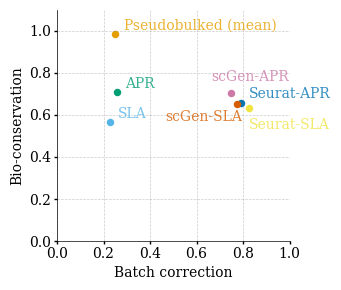

In [47]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.rcParams.update({
    'font.size': 10,              # Default text size
    'axes.titlesize': 12,         # Title size of the axes
    'axes.labelsize': 10,         # Size of the x and y labels
    'xtick.labelsize': 10,         # Size of the x tick labels
    'ytick.labelsize': 10,         # Size of the y tick labels
    'legend.fontsize': 10,         # Font size of the legend
    'figure.titlesize': 12,        # Size of the figure title

    'grid.linewidth': 0.5,
    'xtick.major.width': 0.1,
    'xtick.minor.width': 0.1,
    'ytick.major.size': 1,
    'ytick.minor.size': 1,
    'grid.alpha': 0.4,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'axes.linewidth': 0.1  # Controls the border line width
})
for i_label, (label, row) in enumerate(scores_scaled.iterrows()):
    ax.scatter(row["Batch correction"], row["Bio conservation"], label=label, s=15, c=colors_blind[i_label])

ax.set_xlabel("Batch correction")
ax.set_ylabel("Bio-conservation")
ax.set_xlim([0,1])
ax.set_ylim([0,1.1])
# annotate methods 
offsets = {'scGen-APR':(-14,9), 'scGen-SLA':(-52, -12), 'Seurat-SLA':(0,-15)}
for ii, (k, v) in enumerate(scores_scaled[["Batch correction", "Bio conservation"]].iterrows()):
    offset = offsets.get(k)
    if offset is None:
        offset = (6,3)
    ax.annotate(
        k,
        v,
        color=colors_blind[ii],
        size=10,
        alpha=.8,
        xytext=offset,
        textcoords="offset points",
    )
ax.margins(0.05)
ax.tick_params(axis='both', which='major', length=2, width=1, direction='out', pad=2)
for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Adjust the border thickness here

ax.spines[['right', 'top']].set_visible(False)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')

plt.show()

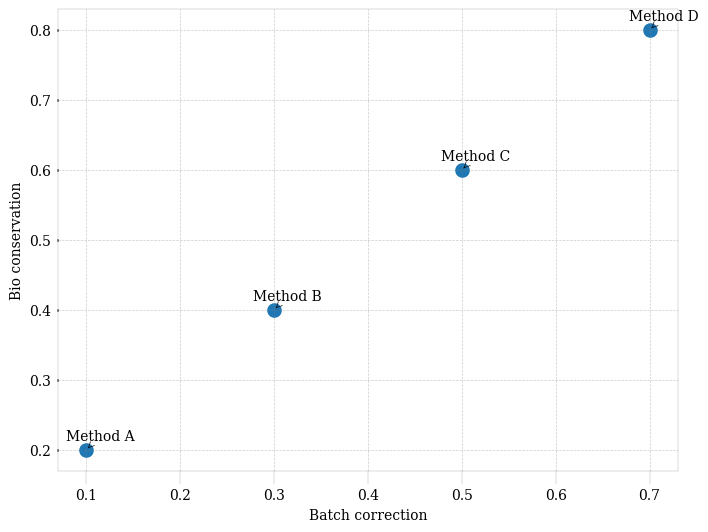

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    "Batch correction": [0.1, 0.3, 0.5, 0.7],
    "Bio conservation": [0.2, 0.4, 0.6, 0.8],
}
scores_scaled = pd.DataFrame(data, index=["Method A", "Method B", "Method C", "Method D"])

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot
ax.scatter(scores_scaled["Batch correction"], scores_scaled["Bio conservation"])

# Annotating with arrows
for k, v in scores_scaled[["Batch correction", "Bio conservation"]].iterrows():
    ax.annotate(
        k,
        xy=v,
        xytext=(10, 10),  # Position of the annotation text relative to the data point
        textcoords="offset points",
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        arrowprops=dict(arrowstyle="->", lw=0.5, color='black')  # Arrow properties
    )

# Labels and grid
ax.set_xlabel('Batch correction')
ax.set_ylabel('Bio conservation')
ax.grid(True, linewidth=0.5)

plt.show()


In [49]:
!pip install adjustText
